# Imports

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from joblib import dump, load

# Set Up Plotting

In [433]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

SE_size = 47.07
ana_thresh_e = 3.5

# Get data

In [434]:
df1 = pd.read_csv('data/tritium_ML_data.csv')
df2 = pd.read_csv('data/bg_sr1_vetoes.csv')
df3 = pd.read_csv('data/bg_sr1_vetoes_gassplit.csv')

df = pd.concat([df1,df3], ignore_index=True)
df = df.drop('Unnamed: 0', axis = 1)
df.head()


,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


# Re-weight data

In [435]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

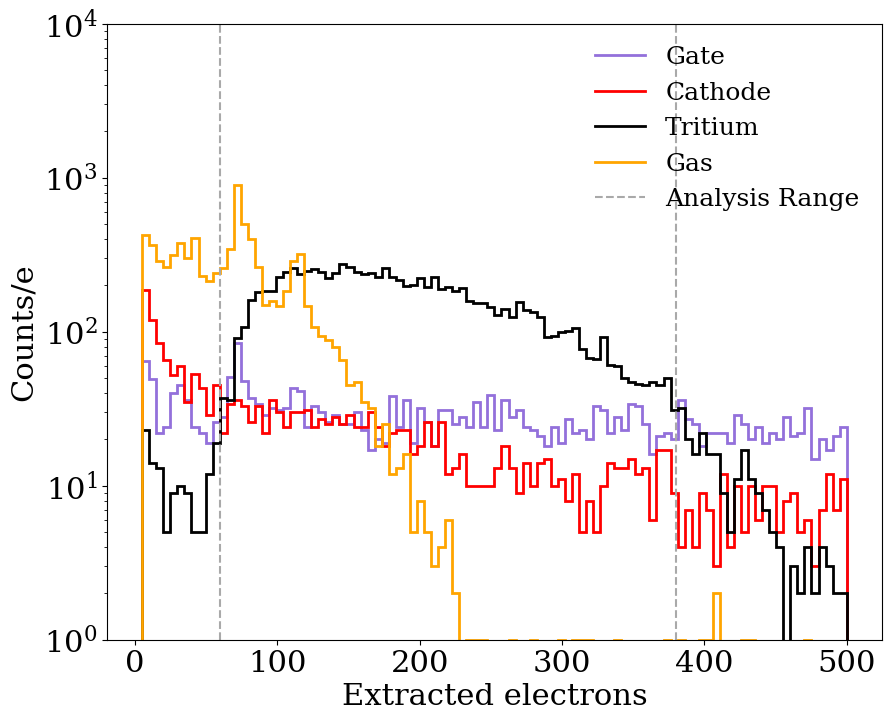

In [436]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
gas_hist.fill(df.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cathode"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [437]:
# implementing thresholds
thresh_cut = (60 < df.ext_elec) & (df.ext_elec < 380)
df_cut_gas = df[thresh_cut].reset_index().drop('index', axis = 1)

In [438]:
# handscanning the weird cathode data bumps 
S2_gate_cut = (100 < df.ext_elec) & (df.ext_elec < 140) 
for ii in range(1,11):
    print('%s\t%s'%(df.runID[S2_gate_cut&gate_cut].to_numpy()[ii], df.eventID[S2_gate_cut&gate_cut].to_numpy()[ii]))
    


6975	17189
6993	33265
6986	30110
7051	83963
7022	141385
6988	3398
7047	3839
7058	18772
7016	50349
6967	66574


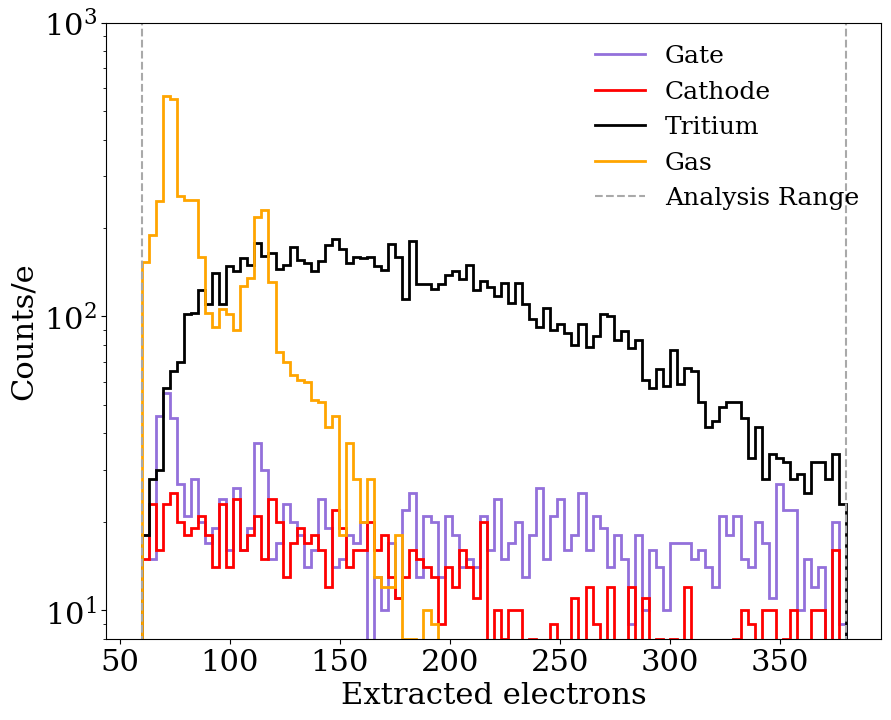

In [439]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_cut_gas.type == "gate"
gate_hist2.fill(df_cut_gas.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_cut_gas.type == "cathode"
cath_hist2.fill(df_cut_gas.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_cut_gas.type == "tritium"
trit_hist2.fill(df_cut_gas.ext_elec[trit_cut2])

gas_hist2 = Hist(electron_axis2)
gas_cut2 = df_cut_gas.type == "gas"
gas_hist2.fill(df_cut_gas.ext_elec[gas_cut2])


fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist2.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,1000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [440]:
#weighting data w/o gas events 
weight_list = []

for ii in range(df_cut_gas.shape[0]):
    if df_cut_gas.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_cut_gas.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_cut_gas.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_cut_gas['weights_no_gas'] = weight_list

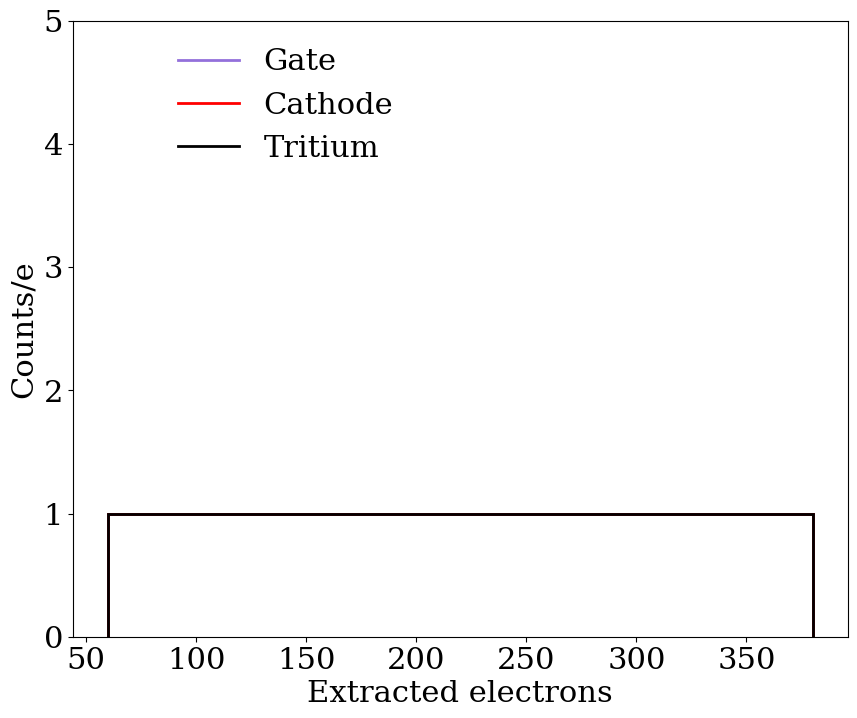

In [441]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_cut_gas.ext_elec[gate_cut2],weight = df_cut_gas.weights_no_gas[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_cut_gas.ext_elec[cath_cut2],weight = df_cut_gas.weights_no_gas[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_cut_gas.ext_elec[trit_cut2],weight = df_cut_gas.weights_no_gas[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

In [442]:
df_cut_gas.loc[df_cut_gas["type"] == "tritium", "label"] = 1
df_cut_gas.loc[df_cut_gas["type"] == "gate", "label"] = 0
df_cut = df_cut_gas[df_cut_gas["type"] != 'gas'] #removing gas events

# Single class Training Dataset

In [443]:
df_gate = df_cut[df_cut["type"] != 'gate']
features = ['max_pulse_height',
       'dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90',
       ]#'ext_elec']

X = df_cut[features]
Y = df_cut['label']
T = df_cut['type']
W = df_cut['weights_no_gas'] # - should this be the weight calculated above? 
A = df_cut['area']
R = df_cut['r']
X_raw = df_cut['x']
Y_raw = df_cut['y']
eventID = df_cut['eventID']
runID = df_cut['runID']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
T_train, T_test, \
W_train, W_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test,  \
eventID_train, eventID_test, \
runID_train, runID_test = \
train_test_split(X, Y, A, T, W, R, X_raw, Y_raw, eventID, runID, random_state=0)

scaler1 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train_unscaled.astype('float64'))
X_test = scaler1.transform(X_test_unscaled.astype('float64'))
E_test = A_test/SE_size

# Width Only Training Dataset

In [444]:
# ML for only pulse width 

features = ['S2_width', 'ext_elec']

X2 = df_cut[features]
Y2 = df_cut['label']
T2 = df_cut['type']
W2 = df_cut['weights_no_gas'] # - should this be the weight calculated above? 
A2 = df_cut['area']
R2 = df_cut['r']
X2_raw = df_cut['x']
Y2_raw = df_cut['y']
X2_train_unscaled, X2_test_unscaled, \
Y2_train, Y2_test, \
A2_train, A2_test, \
T2_train, T2_test, \
W2_train, W2_test, \
R2_train, R2_test, \
X2_raw_train, X2_raw_test, \
Y2_raw_train, Y2_raw_test = \
train_test_split(X2, Y2, A2, T2, W2, R2, X2_raw, Y2_raw, random_state=0)

scaler2 = MinMaxScaler()
X2_train = scaler2.fit_transform(X2_train_unscaled.astype('float64'))
X2_test = scaler2.transform(X2_test_unscaled.astype('float64'))
E2_test = A2_test/SE_size

# Load in all models

In [445]:
single_class_model = load('Single Class Best Result/optimised_singleclass_BDT.joblib')
multiclass_model = load('After Optimising Hypers (multiclass best result)/optimised_multiclass_BDT.joblib')
width_only_model = load('Optimised Width Only/optimised_widthonly_BDT.joblib')

In [446]:
sc_Y_score = single_class_model.decision_function(X_test)
wo_Y_score = width_only_model.decision_function(X2_test)

print(wo_Y_score)

print(single_class_model.score(X_train, Y_train, sample_weight=W_train.astype('float64')))
print(single_class_model.score(X_test, Y_test, sample_weight=W_test.astype('float64')))
print(width_only_model.score(X2_train, Y2_train, sample_weight=W2_train.astype('float64')))
print(width_only_model.score(X2_test, Y2_test, sample_weight=W2_test.astype('float64')))

[ 21.13624103  35.83563423  34.77458666 ...  35.37683882  35.9643584
 -27.62393535]
1.0
0.8320640492886837
1.0
0.6420816765175659


In [447]:
bin_labels = ['Total', r'60 < $n_e$ < 100', r'100 < $n_e$ < 140', r'140 < $n_e$ < 180', r'180 < $n_e$ < 220',
              r'220 < $n_e$ < 240', r'240 < $n_e$ < 280', r'280 < $n_e$ < 320', r'320 < $n_e$ < 380']
bin_colors = ["black", "purple", "darkblue", "cyan", "green", "gold", "orange", "red", "hotpink"  ]

# Single Class Discrimination Analysis

In [448]:
bin1 = (60 < E_test) & (E_test < 100) 
bin2 = (100 < E_test) & (E_test < 140) 
bin3 = (140 < E_test) & (E_test < 180) 
bin4 = (180 < E_test) & (E_test < 220) 
bin5 = (220 < E_test) & (E_test < 260) 
bin6 = (260 < E_test) & (E_test < 300) 
bin7 = (300 < E_test) & (E_test < 340) 
bin8 = (340 < E_test) & (E_test < 380) 
bin_cuts = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8] 

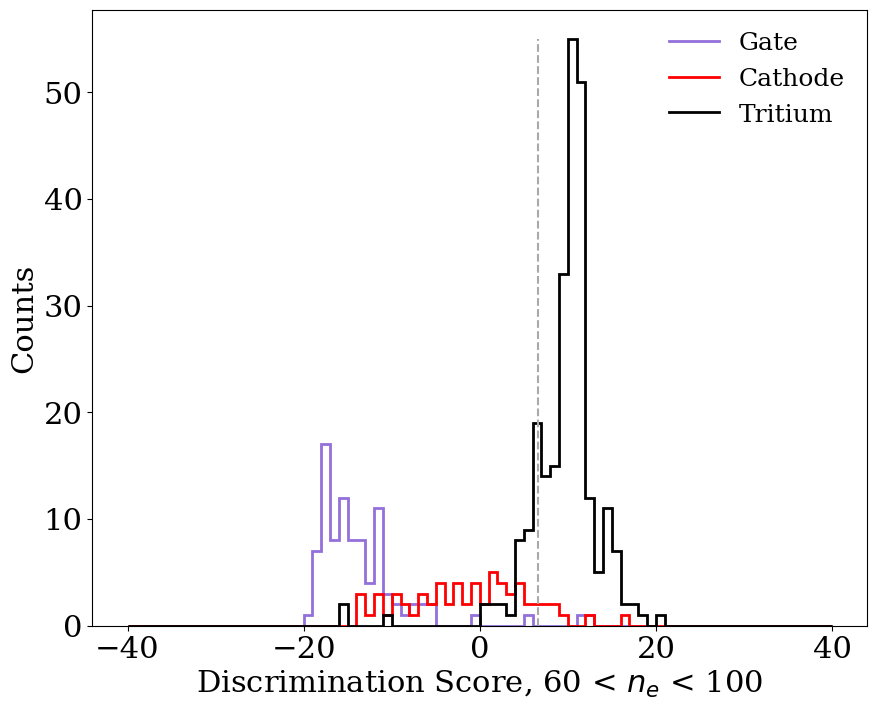

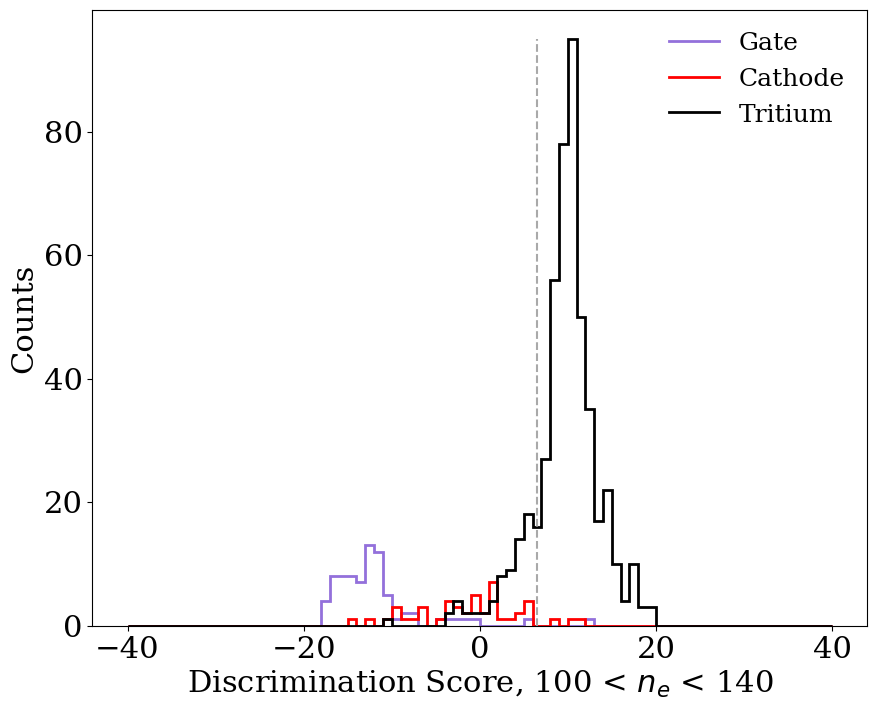

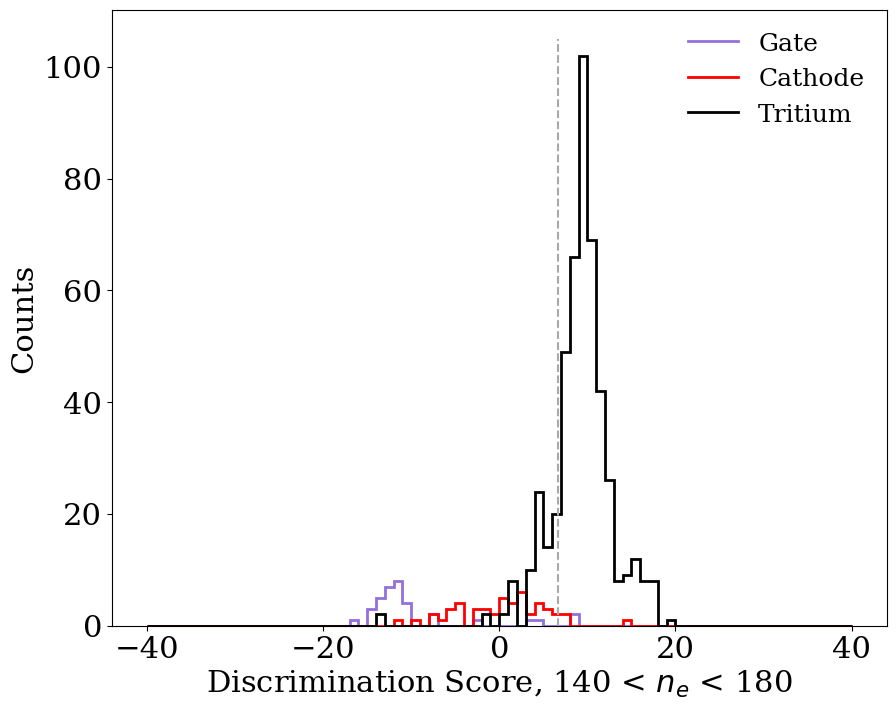

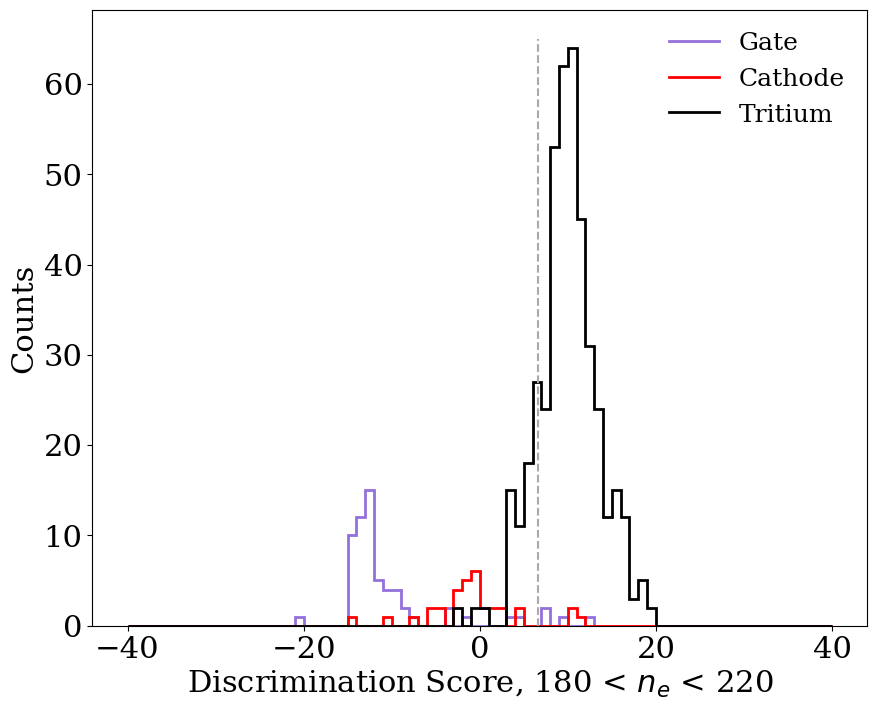

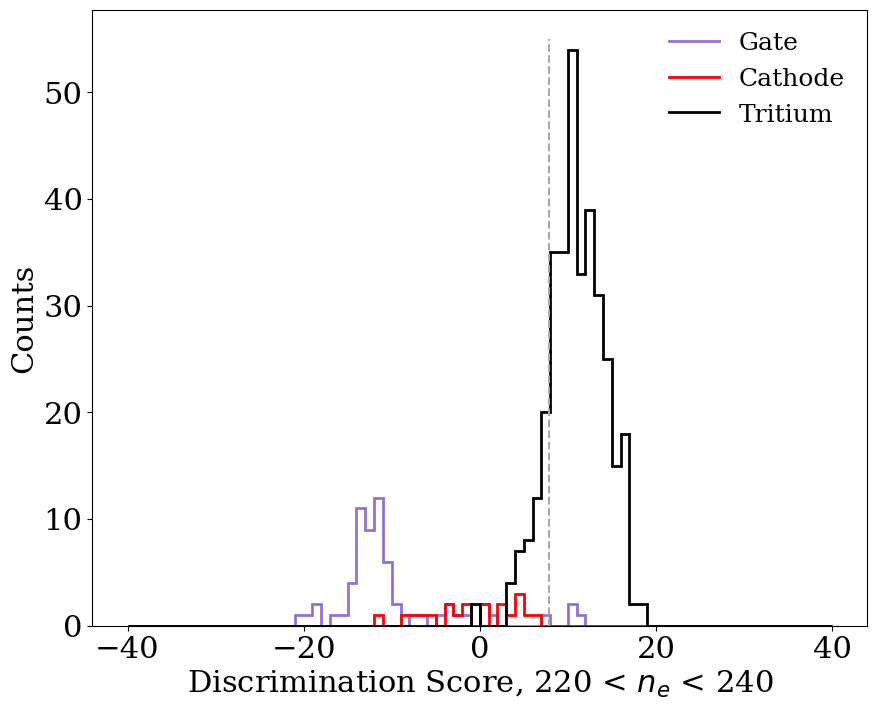

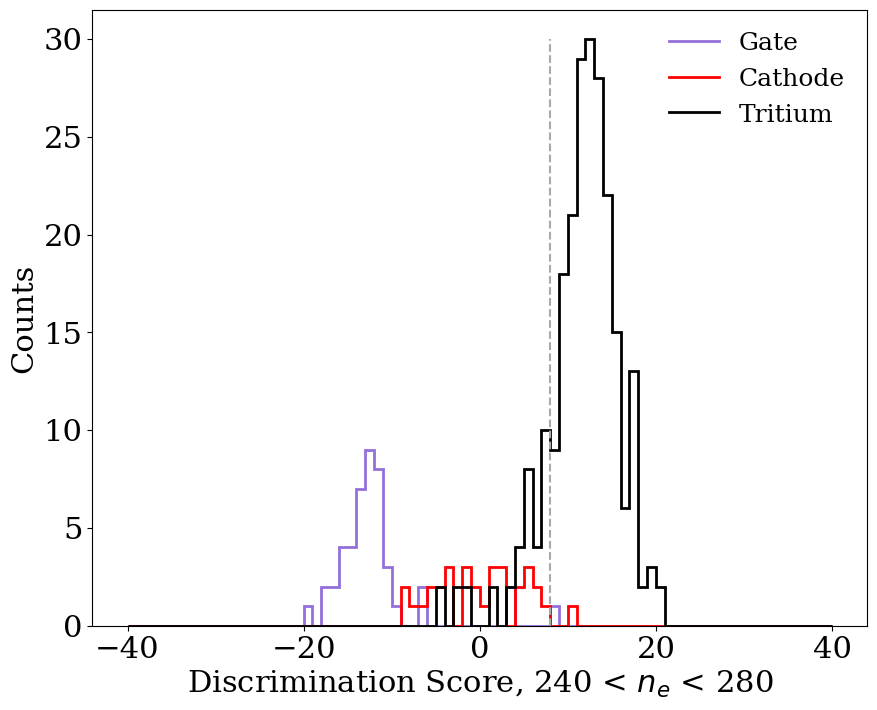

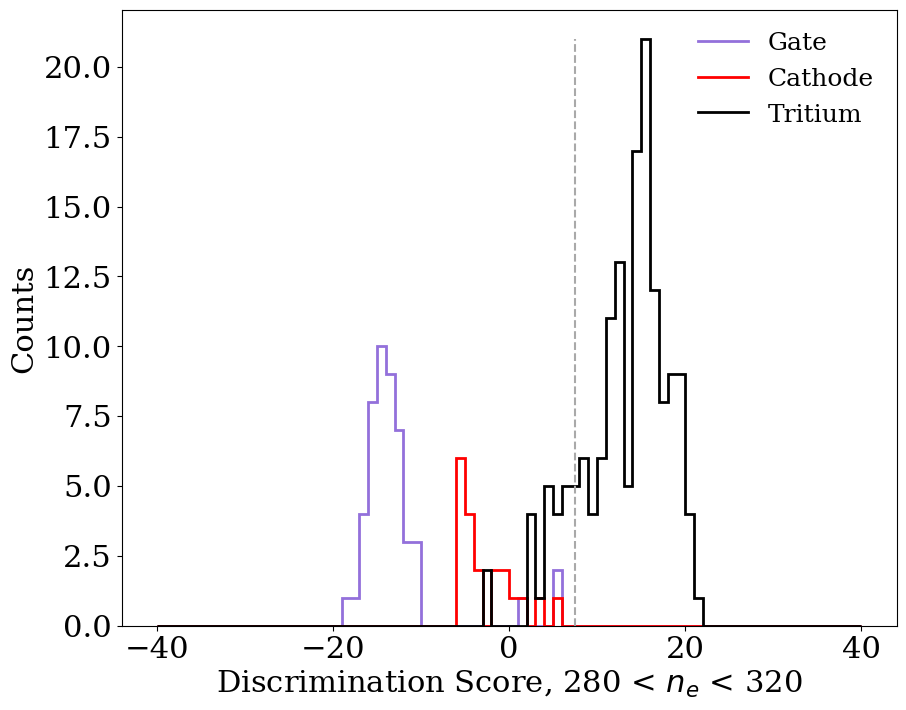

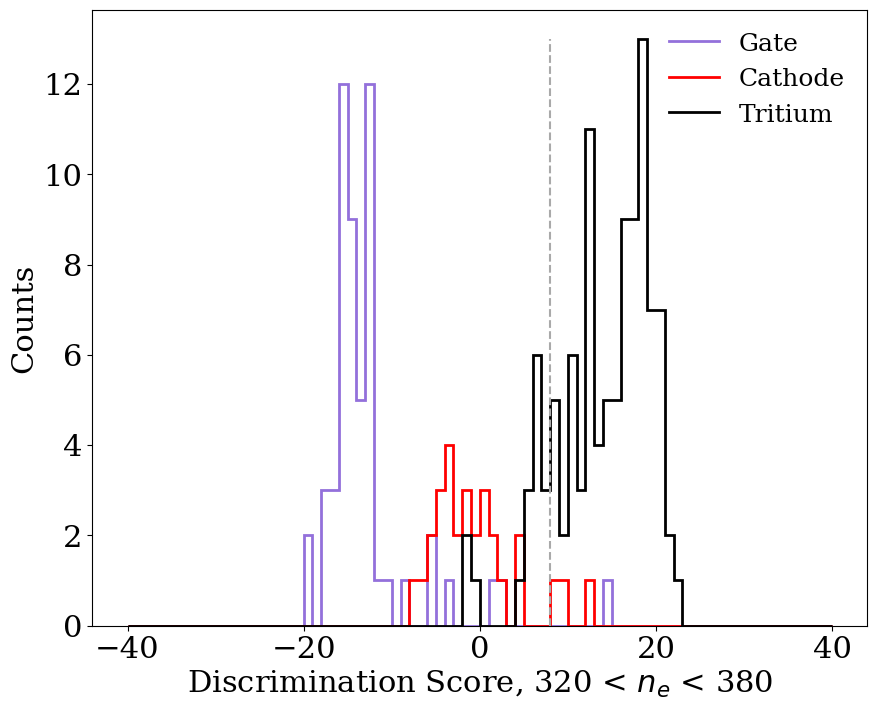

In [449]:
tops = [55,95,105,65,55,30,21,13]
y_score_axis =  hist.axis.Regular(80,-40,40,name="disc_score", label="Discrimination Score",flow=False)
cutoffs = []
disc_cuts = []
trit_effs = [[],[]]
cath_effs = [[],[]]
gate_effs = [[],[]]
for i in range(8):

    trit_score_hist = Hist(y_score_axis)
    trit_cut = T_test == 'tritium'
    trit_score_hist.fill(sc_Y_score[trit_cut&bin_cuts[i]])

    gate_score_hist = Hist(y_score_axis)
    gate_cut = T_test == 'gate'
    gate_score_hist.fill(sc_Y_score[gate_cut&bin_cuts[i]])

    cath_score_hist = Hist(y_score_axis)
    cath_cut = T_test == 'cathode'
    cath_score_hist.fill(sc_Y_score[cath_cut&bin_cuts[i]])

    fig, ax = plt.subplots(figsize=(10, 8))
    gate_score_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
    cath_score_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
    trit_score_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
    
    loc = int(np.round(len(sc_Y_score[trit_cut&bin_cuts[i]])*0.15)) 
    cutoff = np.sort(sc_Y_score[trit_cut&bin_cuts[i]])[loc]
    cutoffs.append(cutoff)
    disc_cut = sc_Y_score > cutoff
    disc_cuts.append(disc_cut)
    
    trit_eff = len(E_test[bin_cuts[i]&trit_cut&disc_cut])/len(E_test[bin_cuts[i]&trit_cut])
    trit_err = np.sqrt(len(E_test[bin_cuts[i]&trit_cut&disc_cut]))/len(E_test[bin_cuts[i]&trit_cut])
    trit_effs[0].append(trit_eff)
    trit_effs[1].append(trit_err)

    gate_eff = 1 - len(E_test[bin_cuts[i]&gate_cut&disc_cut])/len(E_test[bin_cuts[i]&gate_cut])
    gate_err = np.sqrt(len(E_test[bin_cuts[i]&gate_cut&disc_cut]))/len(E_test[bin_cuts[i]&gate_cut])
    gate_effs[0].append(gate_eff)
    gate_effs[1].append(gate_err)
    
    cath_eff = 1 - len(E_test[bin_cuts[i]&cath_cut&disc_cut])/len(E_test[bin_cuts[i]&cath_cut])
    cath_err = np.sqrt(len(E_test[bin_cuts[i]&cath_cut&disc_cut]))/len(E_test[bin_cuts[i]&cath_cut])
    cath_effs[0].append(cath_eff)
    cath_effs[1].append(cath_err)
    
    ax.set(xlabel='Discrimination Score, %s'%(bin_labels[i+1]),ylabel='Counts')
    ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)
    ax.plot([cutoff,cutoff], [0,tops[i]], linestyle='--', color='darkgray')
    
    #plt.savefig('%s'%(i))
    plt.show()

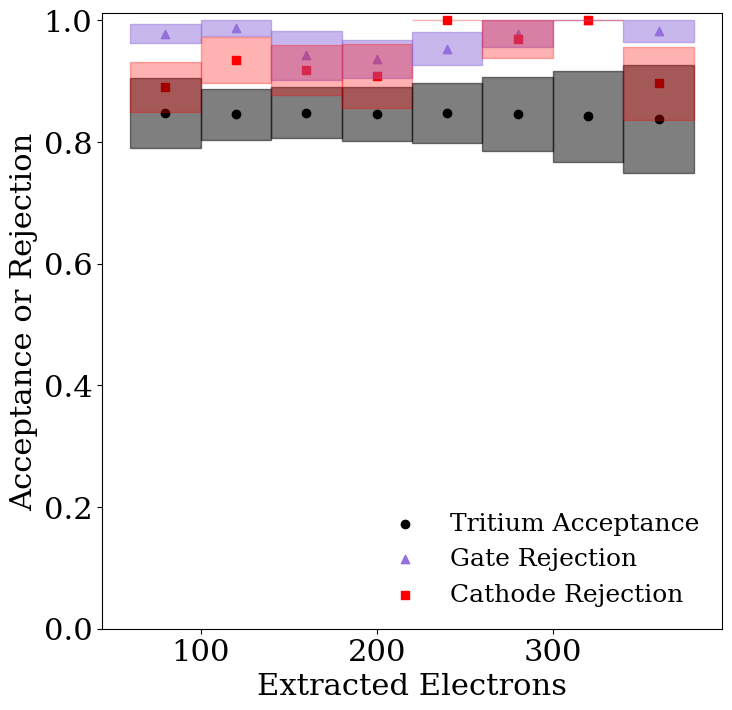

In [450]:
bin_centres = [80, 120, 160, 200, 240, 280, 320, 360]
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bin_centres, trit_effs[0], label = 'Tritium Acceptance', color = 'black')
ax.scatter(bin_centres, gate_effs[0], label = 'Gate Rejection', color = 'mediumpurple', marker = '^')
ax.scatter(bin_centres, cath_effs[0], label = 'Cathode Rejection', color = 'red', marker = 's')

for i in range(8):
    trit_rec = Rectangle((bin_centres[i]-20, trit_effs[0][i]-trit_effs[1][i]), 40, 2*trit_effs[1][i], color = 'black', alpha = 0.5)
    gate_rec = Rectangle((bin_centres[i]-20, gate_effs[0][i]-gate_effs[1][i]), 40, 2*gate_effs[1][i], color = 'mediumpurple', alpha = 0.5)
    cath_rec = Rectangle((bin_centres[i]-20, cath_effs[0][i]-cath_effs[1][i]), 40, 2*cath_effs[1][i], color = 'red', alpha = 0.3)
    ax.add_patch(trit_rec)
    ax.add_patch(gate_rec)
    ax.add_patch(cath_rec)
ax.set_ylim(0)
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 18)
ax.set_xlabel('Extracted Electrons')
ax.set_ylabel('Acceptance or Rejection')
plt.savefig('disc_plot_best.svg')

# Width Only Discrimination Analysis

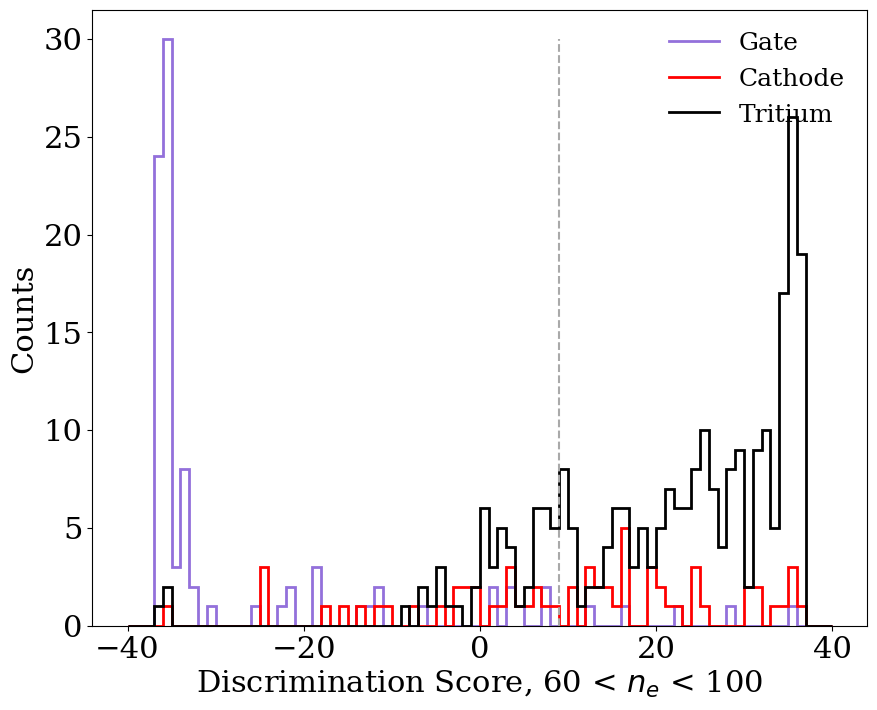

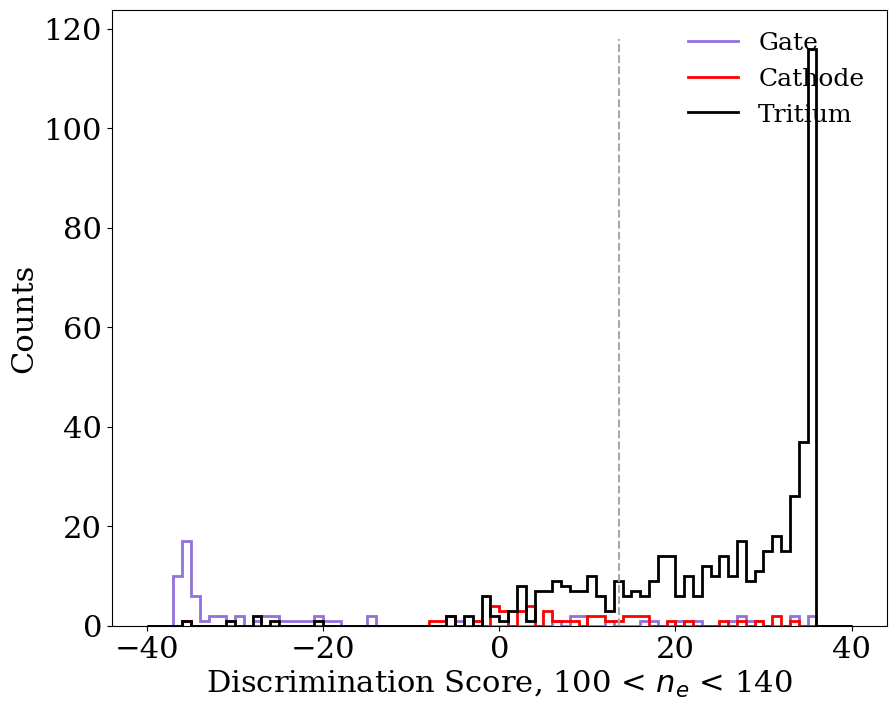

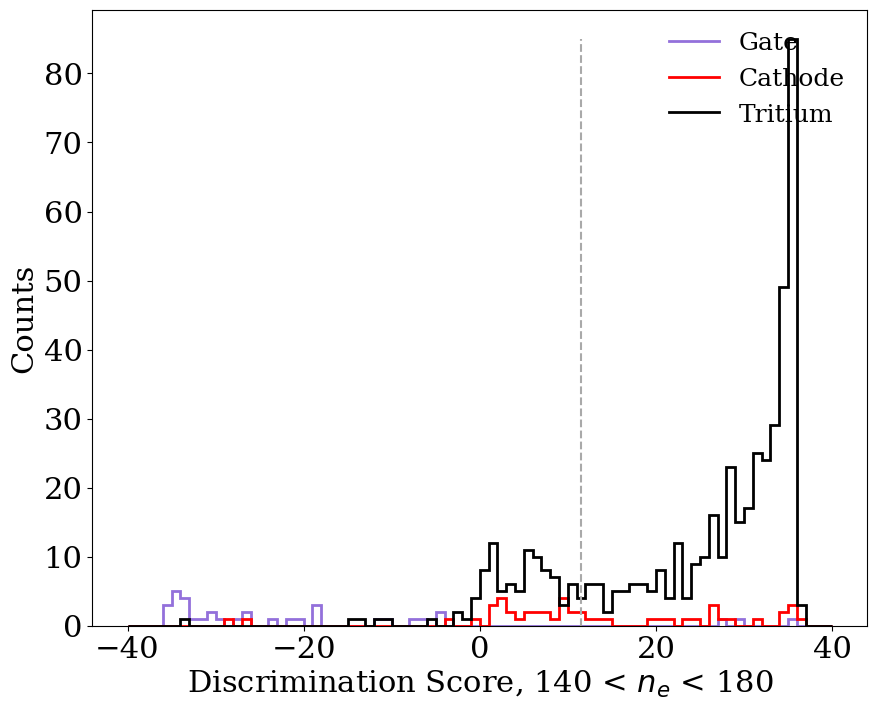

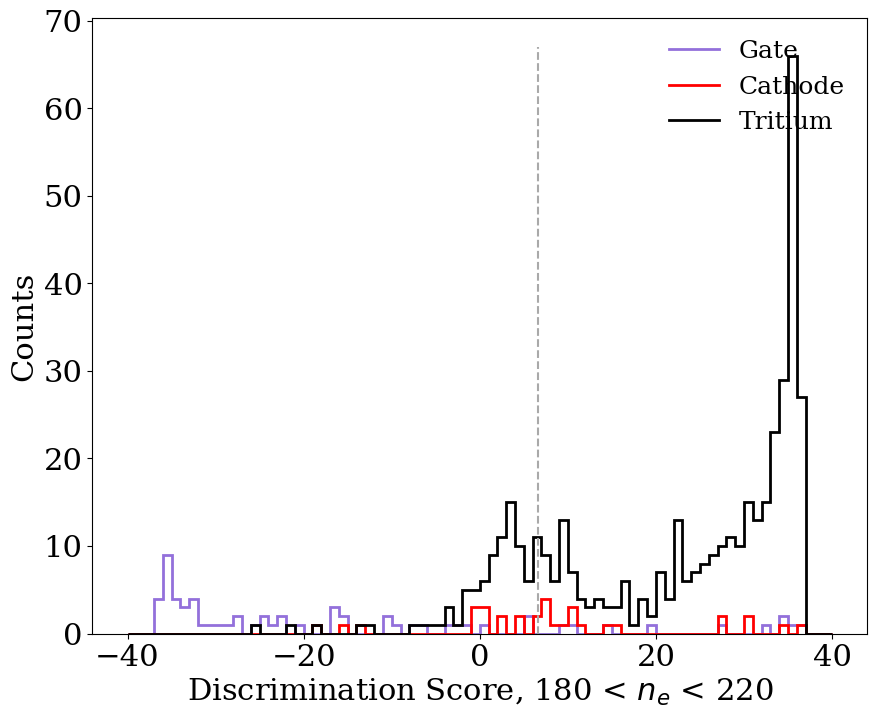

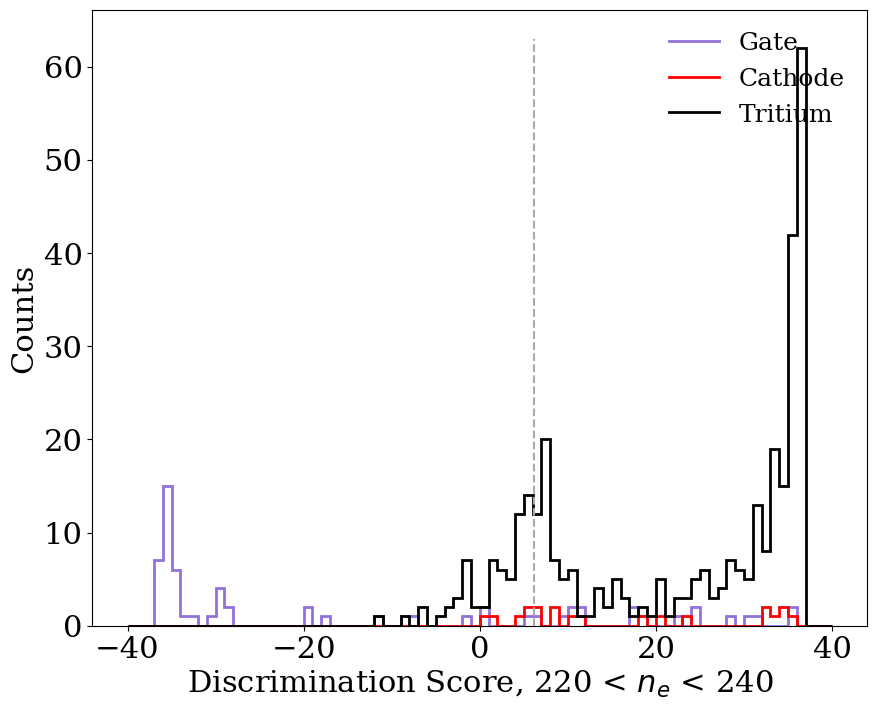

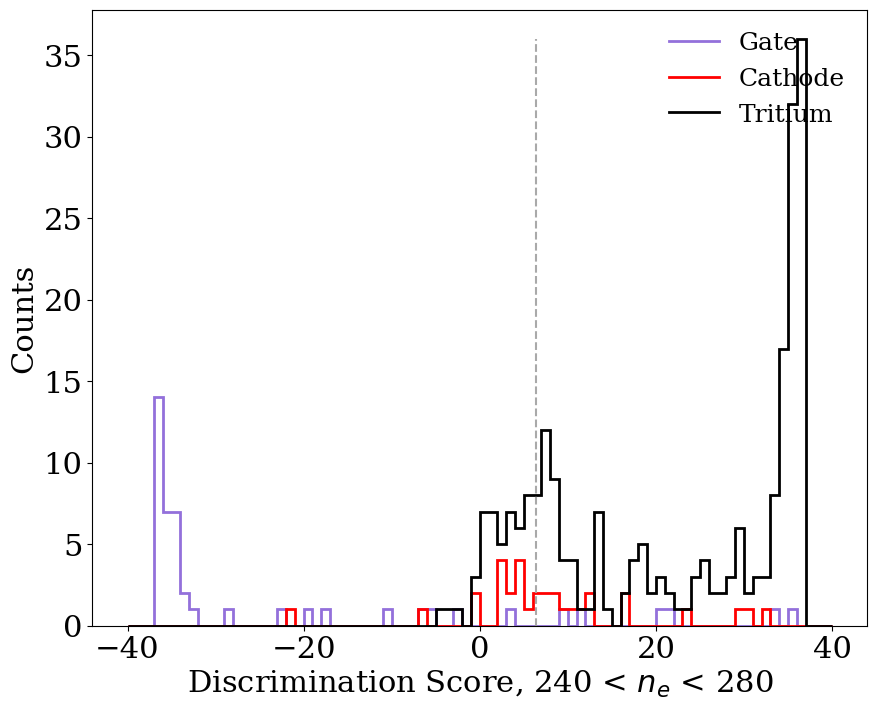

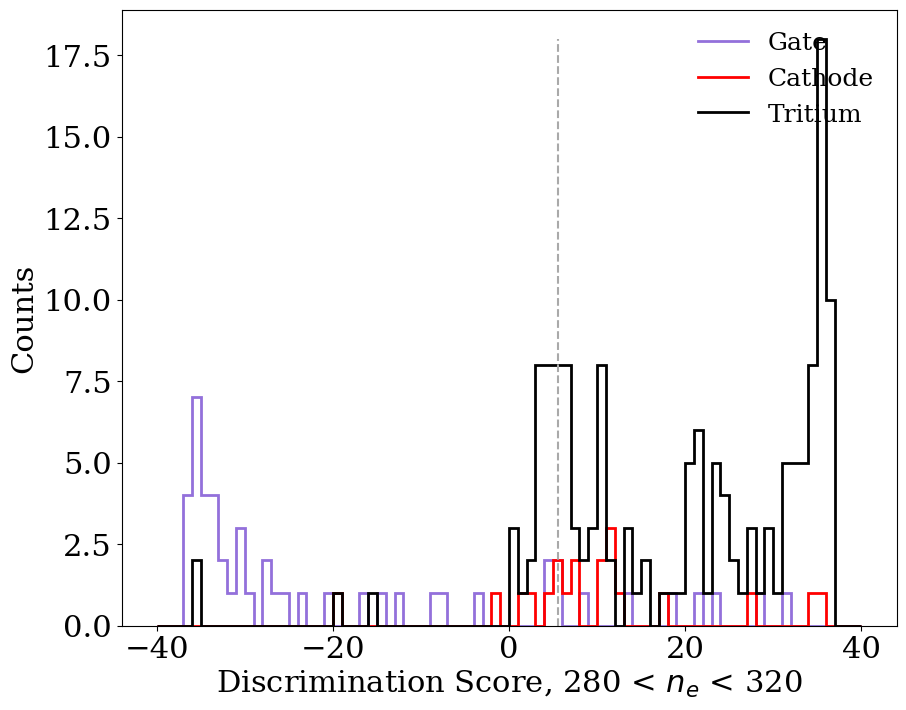

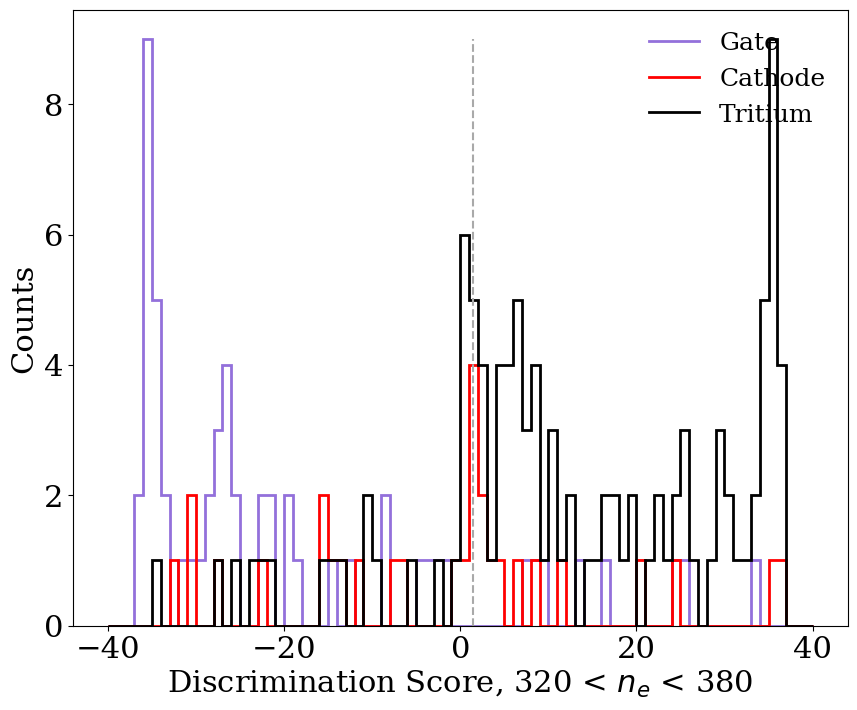

In [451]:
#width_test = X2_test['S2_width']

cutoffs2 = []
disc_cuts2 = []
trit_effs2 = [[],[]]
cath_effs2 = [[],[]]
gate_effs2 = [[],[]]
# trit_cut_data = {'data':[]}
# cath_cut_data = {'data':[]}
# gate_cut_data = {'data':[]}
tops2 = [30,118,85,67,63,36,18,9]
for i in range(8):

    trit_score_hist2 = Hist(y_score_axis)
    trit_cut = T2_test == 'tritium'
    trit_score_hist2.fill(wo_Y_score[trit_cut&bin_cuts[i]])

    gate_score_hist2 = Hist(y_score_axis)
    gate_cut = T2_test == 'gate'
    gate_score_hist2.fill(wo_Y_score[gate_cut&bin_cuts[i]])

    cath_score_hist2 = Hist(y_score_axis)
    cath_cut = T2_test == 'cathode'
    cath_score_hist2.fill(wo_Y_score[cath_cut&bin_cuts[i]])

    fig, ax = plt.subplots(figsize=(10, 8))
    gate_score_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
    cath_score_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
    trit_score_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
    
    loc = int(np.round(len(wo_Y_score[trit_cut&bin_cuts[i]])*0.2)) 
    cutoff = np.sort(wo_Y_score[trit_cut&bin_cuts[i]])[loc]
    cutoffs2.append(cutoff)
    disc_cut = wo_Y_score > cutoff
    disc_cuts2.append(disc_cut)
    
    trit_eff = len(E2_test[bin_cuts[i]&trit_cut&disc_cut])/len(E2_test[bin_cuts[i]&trit_cut])
    trit_err = np.sqrt(len(E2_test[bin_cuts[i]&trit_cut&disc_cut]))/len(E2_test[bin_cuts[i]&trit_cut])
    trit_effs2[0].append(trit_eff)
    trit_effs2[1].append(trit_err)
    # trit_cut_data['data'] = trit_cut_data['data'] + list(width_test[bin_cuts[i]&trit_cut&disc_cut])
    
    gate_eff = 1 - len(E2_test[bin_cuts[i]&gate_cut&disc_cut])/len(E2_test[bin_cuts[i]&gate_cut])
    gate_err = np.sqrt(len(E2_test[bin_cuts[i]&gate_cut&disc_cut]))/len(E2_test[bin_cuts[i]&gate_cut])
    gate_effs2[0].append(gate_eff)
    gate_effs2[1].append(gate_err)
    # gate_cut_data['data'] = gate_cut_data['data'] + list(width_test[bin_cuts[i]&gate_cut&disc_cut])

    
    cath_eff = 1 - len(E2_test[bin_cuts[i]&cath_cut&disc_cut])/len(E2_test[bin_cuts[i]&cath_cut])
    cath_err = np.sqrt(len(E2_test[bin_cuts[i]&cath_cut&disc_cut]))/len(E2_test[bin_cuts[i]&cath_cut])
    cath_effs2[0].append(cath_eff)
    cath_effs2[1].append(cath_err)
    # cath_cut_data['data'] = cath_cut_data['data'] + list(width_test[bin_cuts[i]&cath_cut&disc_cut])

    
    
    ax.set(xlabel='Discrimination Score, %s'%(bin_labels[i+1]),ylabel='Counts')
    ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)
    ax.plot([cutoff,cutoff], [0,tops2[i]], linestyle='--', color='darkgray')
    
    #plt.savefig('%s'%(i))
    
    plt.show()

Text(0, 0.5, 'Acceptance or Rejection ')

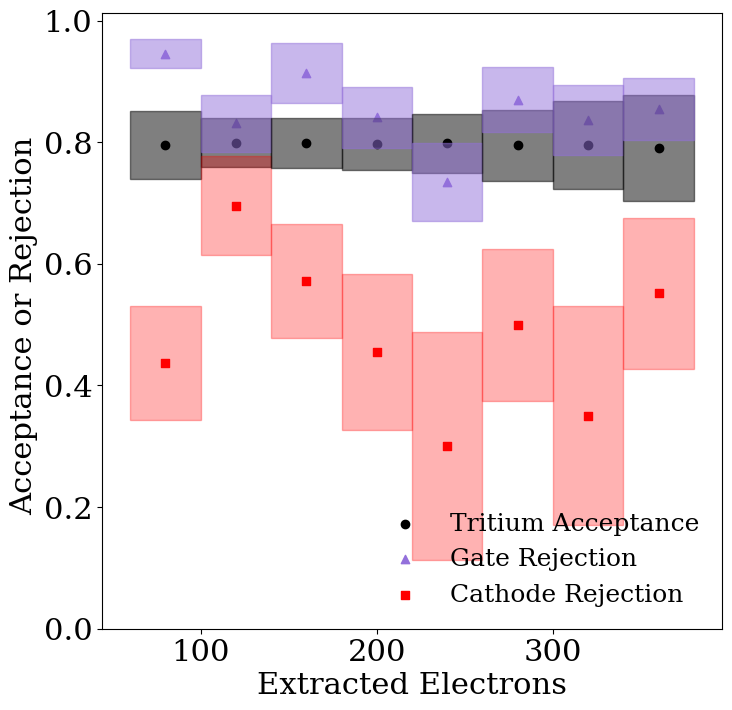

In [452]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bin_centres, trit_effs2[0], label = 'Tritium Acceptance', color = 'black')
ax.scatter(bin_centres, gate_effs2[0], label = 'Gate Rejection', color = 'mediumpurple', marker = '^')
ax.scatter(bin_centres, cath_effs2[0], label = 'Cathode Rejection', color = 'red', marker = 's')

for i in range(8):
    trit_rec = Rectangle((bin_centres[i]-20, trit_effs2[0][i]-trit_effs2[1][i]), 40, 2*trit_effs2[1][i], color = 'black', alpha = 0.5)
    gate_rec = Rectangle((bin_centres[i]-20, gate_effs2[0][i]-gate_effs2[1][i]), 40, 2*gate_effs2[1][i], color = 'mediumpurple', alpha = 0.5)
    cath_rec = Rectangle((bin_centres[i]-20, cath_effs2[0][i]-cath_effs2[1][i]), 40, 2*cath_effs2[1][i], color = 'red', alpha = 0.3)
    ax.add_patch(trit_rec)
    ax.add_patch(gate_rec)
    ax.add_patch(cath_rec)
ax.set_ylim(0)
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 18)
ax.set_xlabel('Extracted Electrons')
ax.set_ylabel('Acceptance or Rejection ')